In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [18]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [19]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [20]:
z500_validation = load_test_data(DATADIR)

/home/rasp/repositories/weather-benchmark/notebooks/src/score.py:24: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(f'{path}/*.nc')[var]
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


## Load forecasts

In [21]:
fc_persistence = xr.open_dataset(f'{PREDDIR}/fc_persistence.nc').z
fc_climatology = xr.open_dataset(f'{PREDDIR}/fc_climatology.nc').z
fc_weekly_climatology = xr.open_dataset(f'{PREDDIR}/fc_weekly_climatology.nc').z

In [22]:
fc_lr_3d = xr.open_dataset(f'{PREDDIR}/fc_lr_3d.nc').__xarray_dataarray_variable__
fc_lr_5d = xr.open_dataset(f'{PREDDIR}/fc_lr_5d.nc').__xarray_dataarray_variable__
fc_lr_6h_iter = xr.open_dataset(f'{PREDDIR}/fc_lr_6h_iter.nc').__xarray_dataarray_variable__

In [23]:
fc_tigge = xr.open_dataset(f'{PREDDIR}/tigge_5.625deg.nc').__xarray_dataarray_variable__

In [24]:
fc_cnn_3d = xr.open_dataset(f'{PREDDIR}/fc_cnn_3d.nc').__xarray_dataarray_variable__
fc_cnn_5d = xr.open_dataset(f'{PREDDIR}/fc_cnn_5d.nc').__xarray_dataarray_variable__
fc_cnn_6h_iter = xr.open_dataset(f'{PREDDIR}/fc_cnn_6h_iter.nc').__xarray_dataarray_variable__

In [25]:
rmses_persistence = evaluate_iterative_forecast(fc_persistence, z500_validation).load()
rmse_climatology = compute_weighted_rmse(fc_climatology, z500_validation).load()
rmse_weekly_climatology = compute_weighted_rmse(fc_weekly_climatology, z500_validation).load()

In [26]:
rmses_lr_6h_iter = evaluate_iterative_forecast(fc_lr_6h_iter, z500_validation).load()
rmse_lr_3d = compute_weighted_rmse(fc_lr_3d, z500_validation).load()
rmse_lr_5d = compute_weighted_rmse(fc_lr_5d, z500_validation).load()

In [75]:
lead_time = 5*24
fc1 = fc_cnn_6h_iter.sel(lead_time=lead_time)
fc2 = fc_lr_6h_iter.sel(lead_time=lead_time)

In [76]:
fc1['time'] = fc1.time + np.timedelta64(int(lead_time), 'h')
fc2['time'] = fc2.time + np.timedelta64(int(lead_time), 'h')

In [77]:
time = '2018-01-01T00'
diff1 = (fc1 - z500_validation).sel(time=time)
diff2 = (fc2 - z500_validation).sel(time=time)

In [78]:
rmse1 = np.sqrt(np.mean(diff1**2)).load()
rmse2 = np.sqrt(np.mean(diff2**2)).load()
rmse1, rmse2

(<xarray.DataArray ()>
 array(1091.9156, dtype=float32)
 Coordinates:
     time       datetime64[ns] 2018-01-01
     lead_time  int64 120, <xarray.DataArray ()>
 array(953.9748, dtype=float32)
 Coordinates:
     time       datetime64[ns] 2018-01-01
     lead_time  int64 120)

In [129]:
rmses1, rmses2 = [], []
time = '2018-06-01T00'
for lead_time in range(6, 121, 6):
    fc1 = fc_cnn_6h_iter.sel(lead_time=lead_time, time=time)
    fc2 = fc_lr_6h_iter.sel(lead_time=lead_time, time=time)
    fc1['time'] = fc1.time + np.timedelta64(int(lead_time), 'h')
    fc2['time'] = fc2.time + np.timedelta64(int(lead_time), 'h')
    rmses1.append(compute_weighted_rmse(fc1, z500_validation.sel(time=time), ['lat', 'lon']).values)
    rmses2.append(compute_weighted_rmse(fc2, z500_validation.sel(time=time), ['lat', 'lon']).values)

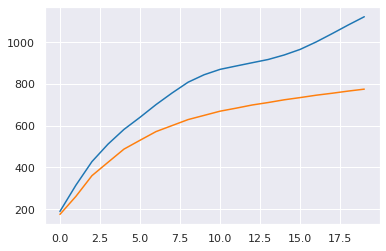

In [130]:
plt.plot(rmses1)
plt.plot(rmses2)

In [103]:
rmses_cnn_6h_iter

<xarray.DataArray (lead_time: 20)>
array([  91.31628502,  143.62309297,  193.79876342,  242.3902929 ,
        293.65614755,  344.48741341,  394.1359211 ,  443.17640135,
        493.03541729,  543.53774787,  593.95759323,  644.17885944,
        694.7409122 ,  745.55334339,  796.1169201 ,  846.04430904,
        895.4071642 ,  944.12723517,  991.92063672, 1038.44246705])
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

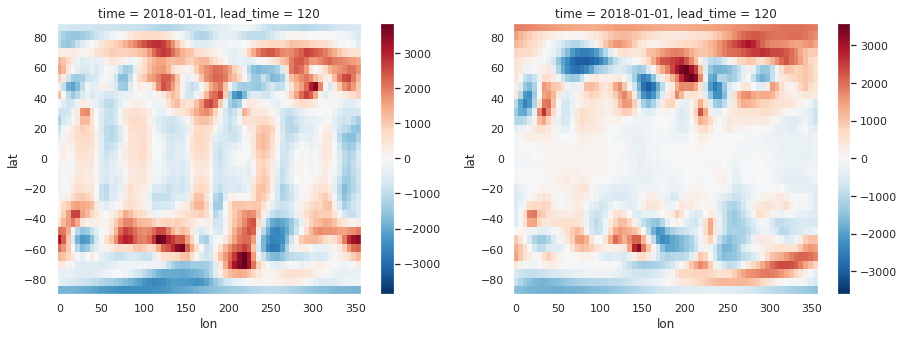

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
diff1.plot(ax=ax1)
diff2.plot(ax=ax2);

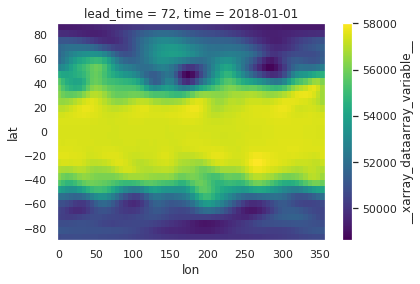

In [62]:
fc2.sel(time='2018-01-01T00').plot()

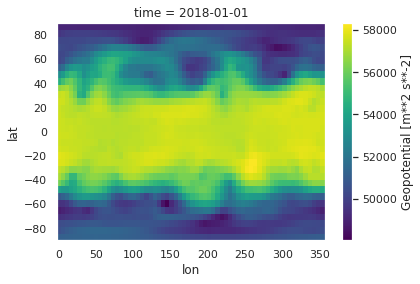

In [61]:
z500_validation.sel(time='2018-01-01T00').plot()

In [51]:
compute_weighted_rmse(fc, z500_validation).load()

<xarray.DataArray ()>
array(1038.44246705)
Coordinates:
    lead_time  int64 120

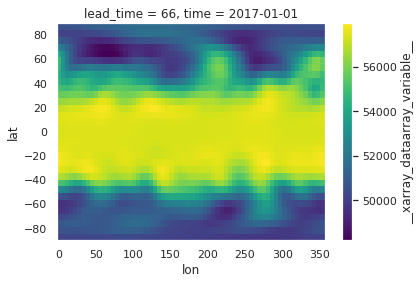

In [41]:
fc_lr_6h_iter.isel(lead_time=10, time=0).plot()

In [27]:
rmses_cnn_6h_iter = evaluate_iterative_forecast(fc_cnn_6h_iter, z500_validation).load()
rmse_cnn_3d = compute_weighted_rmse(fc_cnn_3d, z500_validation).load()
rmse_cnn_5d = compute_weighted_rmse(fc_cnn_5d, z500_validation).load()

In [28]:
rmses_tigge = evaluate_iterative_forecast(fc_tigge, z500_validation).load()

In [85]:
rmses_cnn_6h_iter

<xarray.DataArray (lead_time: 20)>
array([  91.31628502,  143.62309297,  193.79876342,  242.3902929 ,
        293.65614755,  344.48741341,  394.1359211 ,  443.17640135,
        493.03541729,  543.53774787,  593.95759323,  644.17885944,
        694.7409122 ,  745.55334339,  796.1169201 ,  846.04430904,
        895.4071642 ,  944.12723517,  991.92063672, 1038.44246705])
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
lr = LinearRegression()

In [90]:
lr.fit(rmses_cnn_6h_iter.lead_time.values[None], rmses_cnn_6h_iter.values[None])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [93]:
preds = lr.predict(rmses_cnn_6h_iter.lead_time.values[None])[0]

In [96]:
rmses_cnn_6h_iter.values-preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

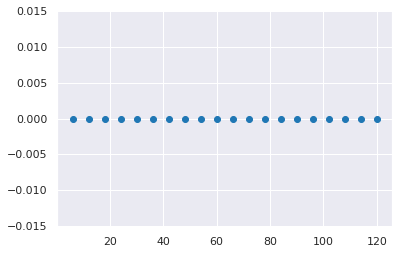

In [95]:
plt.scatter(rmses_cnn_6h_iter.lead_time.values, rmses_cnn_6h_iter.values-preds)


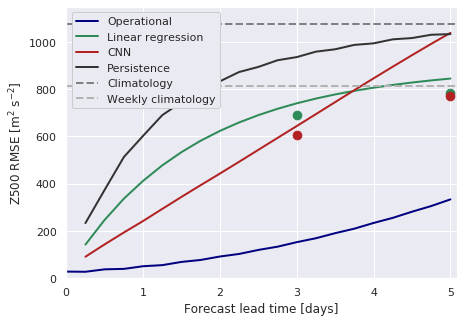

In [29]:
c_lr = 'seagreen'
c_cnn = 'firebrick'
c_tigge = 'navy'
c_persistence = '0.2'
c_climatology = '0.5'
c_weekly_climatology = '0.7'
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
rmses_tigge.plot(c=c_tigge, label='Operational', lw=2)
rmses_lr_6h_iter.plot(c=c_lr, label='Linear regression', lw=2)
rmses_cnn_6h_iter.plot(c=c_cnn, label='CNN', lw=2)
rmses_persistence.plot(c=c_persistence, label='Persistence', lw=2)
ax.axhline(rmse_climatology, ls='--', c=c_climatology, label='Climatology', lw=2)
ax.axhline(rmse_weekly_climatology, ls='--', c=c_weekly_climatology, label='Weekly climatology', lw=2)
plt.scatter([3*24], [rmse_lr_3d], c=c_lr, s=75)
plt.scatter([5*24], [rmse_lr_5d], c=c_lr, s=75)
plt.scatter([3*24], [rmse_cnn_3d], c=c_cnn, s=75)
plt.scatter([5*24], [rmse_cnn_5d], c=c_cnn, s=75)
plt.legend(loc=2, framealpha=1)
plt.xlim(0, 122)
plt.ylim(0, 1150)
plt.xticks(range(0, 121, 24), range(0, 6))
plt.xlabel('Forecast lead time [days]')
plt.ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]');